In [1]:
from maze import Maze
from robot import Robot
from take_n_steps import take_n_steps
from print_maze import print_maze
from show_path import show_times_visited, show_multiple_path, show_step_count
import numpy as np
import pandas as pd

In [7]:
first1_paths = []
first2_paths = []
second1_paths = []
second2_paths = []
goal2start_paths = []
u_table_history = []
second1_bad = []

next_locations = []

# Create a maze and robots
testmaze = Maze("test_maze_03.txt")
testrobots = []
for run in range(100):
    testrobots.append(Robot(testmaze.dim))
    

for testrobot in testrobots:
    robot_pos = {'location': [0, 0], 'heading': 'u'}
    u_table_history.append([])
    next_locations.append([])
    
    #find the goal
    while len(testrobot.path_taken) < 1000 and not testrobot.found_goal:
        robot_pos = take_n_steps(1, testmaze, testrobot, robot_pos)
        u_table_history[-1].append(testrobot.U_table_to_goal)
    first1_paths.append(testrobot.path_taken_to_goal)
    #second1_paths.append(testrobot.a_star((0,0),testrobot.goal,testrobot.next_locations_table,testrobot.maze_dim))
    second1_paths.append(testrobot.best_path)
    next_locations[-1].append(testrobot.next_locations_table)

    #second1_bad.append(a_star((0,0),testrobot.goal,testrobot.next_locations_table,testrobot.maze_dim))
    
    while len(testrobot.path_taken) < 1000 and not testrobot.finished_exploring:
        robot_pos = take_n_steps(1, testmaze, testrobot, robot_pos)
    first2_paths.append(testrobot.path_taken)
    #second2_paths.append(testrobot.a_star((0,0),testrobot.goal,testrobot.next_locations_table,testrobot.maze_dim))
    second2_paths.append(testrobot.best_path)
    
first1_lengths = [len(x[1:]) for x in first1_paths]
first2_lengths = [len(x[1:]) for x in first2_paths]
second1_lengths = [len(x[1:]) for x in second1_paths]
second2_lengths = [len(x[1:]) for x in second2_paths]

#second1_bad_len = [len(x[1:]) for x in second1_bad]

scores1 = [first/30.0 + second for first,second in zip(first1_lengths,second1_lengths)]
scores2 = [first/30.0 + second for first,second in zip(first2_lengths,second2_lengths)]

results = {"first1":first1_lengths, 
           "second1":second1_lengths,
           "score1":scores1,
           "first2":first2_lengths, 
           "second2":second2_lengths,
           "score2":scores2}

#results = {"second1":second1_lengths,"second1_bad":second1_bad_len} 

df = pd.DataFrame(results)

In [8]:
df[['first1','second1','score1','first2','second2','score2']].describe()

,first1,second1,score1,first2,second2,score2
count,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000
mean,82.290000,29.68000,32.423000,134.170000,29.590000,34.062333
std,9.206163,1.22993,1.193564,18.817601,1.378735,1.404679
min,64.000000,28.00000,30.133333,80.000000,25.000000,30.266667
25%,75.000000,29.00000,31.641667,123.750000,29.000000,33.191667
50%,81.500000,29.00000,32.216667,133.500000,29.000000,34.366667
75%,88.250000,31.00000,33.533333,146.000000,31.000000,35.200000
max,102.000000,31.00000,34.400000,174.000000,31.000000,36.366667


In [11]:
len(df[df['first1']<=1000])

47

In [11]:
#df[df['score2']>21]
df[df['second2']<df['second1']]
#df2[df2['score2']<df2['score1']]

,first1,first2,score1,score2,second1,second2
10,80,143,31.666667,31.766667,29,27
43,74,139,31.466667,31.633333,29,27
70,75,139,31.500000,31.633333,29,27
84,93,158,31.100000,30.266667,28,25


In [19]:
#i = short_index[1]
i =3
print "Best Path 1 = " + str(second1_lengths[i])
print "Best Path 2 = " + str(second2_lengths[i])
print "Score1 = " + str(scores1[i])
print "Score2 = " + str(scores2[i])
print "Len of path to start = " + str(len(testrobots[i].path_taken_to_start))
show_multiple_path(testmaze,[testrobots[i].path_taken_to_goal,testrobots[i].path_taken_to_start]) 

Best Path 1 = 18
Best Path 2 = 18
Score1 = 20.5666666667
Score2 = 20.8333333333
Len of path to start = 8
steps:85
                            LEFT                        
          0   1   2   3   4   5   6   7   8   9   10  11 
        +---+---+---+---+---+---+---+---+---+---+---+---+
     0  | 0           0           0                     |
        +---+---    +---+---+---    +---    +---+---    +
     1  |           |                   |               |
            +---            +---    +---+---+---    +---+
     2  |       |   |   |     0   0     | 0   0   0   0 |
                        +---    +---        +---+---+---+
     3  |   |           | 0   0   0     | 0   0   0   0 |
            +---+---+---    +---+---+---+---+---        +
     4  |           | 0   0   0   0   0   0   0 | 0 |   |
DOWN    +---+---            +---+---        +---        +  UP
     5  |         0   0 | 0 |       | 0 | 0   0 | 0 | 0 |
            +---                                        +
     6  |    

In [9]:
testrobots[i].path_taken_to_goal

[(0, 0),
 (0, 3),
 (0, 6),
 (2, 6),
 (2, 5),
 (3, 5),
 (3, 6),
 (3, 7),
 (2, 7),
 (2, 4),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 6),
 (2, 6),
 (2, 5),
 (3, 5),
 (3, 4),
 (6, 4),
 (5, 4),
 (6, 4),
 (6, 3),
 (5, 3),
 (5, 2),
 (6, 2),
 (6, 1),
 (7, 1),
 (7, 3),
 (4, 3),
 (4, 5),
 (4, 6),
 (4, 7),
 (6, 7),
 (5, 7),
 (6, 7),
 (6, 8),
 (5, 8),
 (5, 9),
 (6, 9),
 (6, 10),
 (5, 10),
 (4, 10),
 (3, 10),
 (3, 8),
 (3, 9),
 (3, 8),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 10),
 (1, 10),
 (1, 8),
 (1, 9),
 (1, 8),
 (0, 8),
 (0, 5),
 (0, 7),
 (0, 4),
 (0, 2),
 (3, 2),
 (3, 3),
 (2, 3),
 (1, 3),
 (1, 5),
 (1, 4),
 (2, 4),
 (2, 7),
 (3, 7),
 (3, 6),
 (3, 4),
 (4, 4),
 (5, 4),
 (4, 4),
 (4, 6),
 (4, 8),
 (7, 8),
 (7, 9),
 (8, 9),
 (8, 10),
 (7, 10),
 (7, 11),
 (6, 11),
 (5, 11),
 (4, 11),
 (3, 11),
 (3, 9),
 (3, 10),
 (6, 10),
 (6, 9),
 (5, 9),
 (5, 8),
 (6, 8),
 (4, 8),
 (4, 9),
 (4, 8),
 (4, 5),
 (4, 7),
 (5, 7),
 (6, 7),
 (5, 7),
 (4, 7),
 (4, 5),
 (4, 3),
 (5, 3),
 (5, 1),
 (5, 0),
 (6, 0),
 (

In [41]:
i = 30
print len(testrobots[i].path_taken_to_start)
#show_step_count(testmaze,testrobots[i].path_taken_to_start[:43][::-1])
#show_step_count(testmaze,testrobots[i].path_taken_to_start[:54][::-1])
show_times_visited(testmaze,testrobots[i].path_taken_to_goal)
#show_step_count(testmaze,testrobots[i].path_taken_to_goal)
#show_times_visited(testmaze,testrobots[i].path_taken_to_goal)
#path1 = [(9,8)]
#path2 = [(9,5),(9,6),(9,7),(9,9),(9,10),(8,8),(10,8),(11,8)]
#show_multiple_path(testmaze,[path1,path2])

9
steps:113
                            LEFT                        
          0   1   2   3   4   5   6   7   8   9   10  11 
        +---+---+---+---+---+---+---+---+---+---+---+---+
     0  | 1       1   1   1   1   1   1   1             |
        +---+---    +---+---+---    +---    +---+---    +
     1  |           | 1   1   2   2   1 | 1       1     |
            +---            +---    +---+---+---    +---+
     2  | 1   1 |   | 2 | 1   2   2   1 | 1   1   1     |
                        +---    +---        +---+---+---+
     3  |   | 1   1   2 | 1   2   1   1 | 2   1   1     |
            +---+---+---    +---+---+---+---+---        +
     4  | 1       1 | 1   2   2   2   2   2   1 | 1 |   |
DOWN    +---+---            +---+---        +---        +  UP
     5  | 1   1   1   2 | 2 |     1 | 2 | 2   2 | 1 |   |
            +---                                        +
     6  | 1   1   1 | 1   2 |       | 3   2 | 1   1   1 |
        +---    +---    +---+---    +---        +---    +

In [197]:
print testrobots[i].times_visited

[[ 1.  0.  0.  1.  0.  0.  1.  1.  0.  0.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  2.  2.  0.  0.  1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  2.  2.  2.  2.  1.  1.  2.  1.  0.  1.]
 [ 0.  0.  0.  0.  1.  1.  2.  1.  1.  2.  2.  1.  1.  0.]
 [ 0.  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.  2.  2.  2.]
 [ 0.  0.  0.  0.  2.  2.  0.  1.  2.  1.  1.  2.  1.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  2.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  2.  1.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  2.  2.  1.  0.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  2.  1.  1.  1.  1.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.]]


In [221]:
def find_loneliness_value(cell):
    mat = np.zeros((testmaze.dim,testmaze.dim))
    times_visited = testrobots[i].times_visited 
    #times_visited = np.ones((testmaze.dim,testmaze.dim))
    for row in range(testmaze.dim):
        for col in range(testmaze.dim):
            mat[row][col] = 1.0/((abs(row - cell[0]) + abs(col - cell[1]))+1)
    return np.sum(times_visited*mat/np.sum(mat))

In [7]:
def create_u_table(cell):
    u_table = np.zeros((testmaze.dim,testmaze.dim))
    for row in range(testmaze.dim):
        for col in range(testmaze.dim):
            if not (row == cell[0] and col == cell[1]):
                u_table[row][col] = -0.1*(abs(row - cell[0]) + abs(col - cell[1]))
    return u_table

In [14]:
#for loc in testrobots[3].path_taken_to_goal:
for row in range(testmaze.dim):
    for col in range(testmaze.dim):
        if testrobots[3].times_visited[row][col] > 0:
            testrobots[3].times_visited[row][col] = 1
print testrobots[3].times_visited

[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  0.  0.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  0.  1.  0.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  0.  1.  0.  0.  0.  1.  1.  1.  0.  0.  1.]
 [ 1.  1.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 1.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.]]


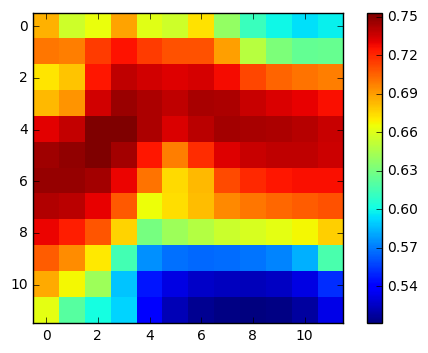

In [17]:
i =10

def get_loneliest_loc():

    loneliest_loc = (0,0)
    loneliest_value = 100
    loneliness_mat = np.zeros((testmaze.dim,testmaze.dim))
    
    def find_loneliness_value(cell):
        mat = np.zeros((testmaze.dim,testmaze.dim))
        visited_mat = np.zeros((testmaze.dim,testmaze.dim))
        for row in range(testmaze.dim):
            for col in range(testmaze.dim):
                mat[row][col] = 1.0/((abs(row - cell[0]) + abs(col - cell[1]))+1)
                if testrobots[i].times_visited[row][col]>0:
                    visited_mat[row][col] = 1
        return np.sum(visited_mat*mat/np.sum(mat))
    
    
    for row in range(testmaze.dim):
        for col in range(testmaze.dim):
            loneliness_mat[row][col] = find_loneliness_value((row,col))
            if loneliness_mat[row][col] < loneliest_value:
                loneliest_value = loneliness_mat[row][col]
                loneliest_loc = (row,col)
    return loneliest_loc, loneliness_mat

loneliest_loc,loneliness_mat = get_loneliest_loc()

#print create_u_table(loneliest_loc)
from matplotlib import pyplot
img = pyplot.imshow(loneliness_mat,interpolation='nearest')
pyplot.colorbar(img)
pyplot.show()

In [18]:
show_times_visited(testmaze,testrobots[i].path_taken)

steps:128
                            LEFT                        
          0   1   2   3   4   5   6   7   8   9   10  11 
        +---+---+---+---+---+---+---+---+---+---+---+---+
     0  | 1           1           1                     |
        +---+---    +---+---+---    +---    +---+---    +
     1  | 1   1   1 | 1   1   1   2   1 |               |
            +---            +---    +---+---+---    +---+
     2  |       | 1 | 1 | 1   1   1   1 | 2   1   1   1 |
                        +---    +---        +---+---+---+
     3  |   |     1   2 | 2   2   2   2 | 2   1   1   1 |
            +---+---+---    +---+---+---+---+---        +
     4  | 1   1   2 | 2   2   2   2   2   1   1 | 1 | 1 |
DOWN    +---+---            +---+---        +---        +  UP
     5  | 1   1   1   2 | 2 |     1 | 2 | 2   2 | 1 | 2 |
            +---                                        +
     6  | 1   1   2 | 2   2 |       | 2   2 | 2   1   2 |
        +---    +---    +---+---    +---        +---    +
 

In [ ]:
def find_loneliness_value2(cell):
    mat = testrobots[i].times_visited
    loneliness_value = 0
    count = 0
    for row in range(-2,3):
        for col in range(-2,3):
            if row + cell[0] in range(0,testmaze.dim) and col + cell[1] in range(0,testmaze.dim):
                count += 1
                loneliness_value += mat[cell[0]+row][cell[1]+col]
                
    #return mat
    return loneliness_value/count

In [159]:
print create_u_table((11,11))

[[ 22.  21.  20.  19.  18.  17.  16.  15.  14.  13.  12.  11.]
 [ 21.  20.  19.  18.  17.  16.  15.  14.  13.  12.  11.  10.]
 [ 20.  19.  18.  17.  16.  15.  14.  13.  12.  11.  10.   9.]
 [ 19.  18.  17.  16.  15.  14.  13.  12.  11.  10.   9.   8.]
 [ 18.  17.  16.  15.  14.  13.  12.  11.  10.   9.   8.   7.]
 [ 17.  16.  15.  14.  13.  12.  11.  10.   9.   8.   7.   6.]
 [ 16.  15.  14.  13.  12.  11.  10.   9.   8.   7.   6.   5.]
 [ 15.  14.  13.  12.  11.  10.   9.   8.   7.   6.   5.   4.]
 [ 14.  13.  12.  11.  10.   9.   8.   7.   6.   5.   4.   3.]
 [ 13.  12.  11.  10.   9.   8.   7.   6.   5.   4.   3.   2.]
 [ 12.  11.  10.   9.   8.   7.   6.   5.   4.   3.   2.   1.]
 [ 11.  10.   9.   8.   7.   6.   5.   4.   3.   2.   1.   0.]]


In [184]:
df[['first1']]

,first1
0,70
1,62
2,67
3,68
4,77
5,65
6,78
7,69
8,89
9,70


In [244]:
i = 50
show_times_visited(testmaze,testrobots[i].path_taken)

steps:78
                                LEFT                            
          0   1   2   3   4   5   6   7   8   9   10  11  12  13 
        +---+---+---+---+---+---+---+---+---+---+---+---+---+---+
     0  | 1           1           1   1 |       |               |
        +---+---+---        +---+---                +---+---    +
     1  |           |   |                   |       |           |
            +---        +---+---+---                            +
     2  |       |       |           |   |   |   |       |   |   |
                        +---                        +---+---    +
     3  |   |       |   |       | 1   2 |       |   |           |
            +---+---        +---                        +---    +
     4  |           |   |     1   1 | 1 |   |       |           |
            +---    +---        +---+---    +---+---+---    +---+
     5  |             1   1 |                       |           |
DOWN            +---            +---+---+---+---+---    +---    +  U

In [216]:
loneliness_mat1 = np.zeros((testmaze.dim,testmaze.dim))
for row in range(testmaze.dim):
    for col in range(testmaze.dim):
    #print find_loneliness_value((row,col))
        loneliness_mat1[row][col] = find_loneliness_value((row,col))

#print loneliness_mat
#print mat
img = pyplot.imshow(loneliness_mat1,interpolation='nearest')
pyplot.colorbar(img)
pyplot.show()

loneliness_mat2 = np.zeros((testmaze.dim,testmaze.dim))
for row in range(testmaze.dim):
    for col in range(testmaze.dim):
    #print find_loneliness_value((row,col))
        loneliness_mat2[row][col] = find_loneliness_value2((row,col))

#print loneliness_mat
#print mat
img = pyplot.imshow(loneliness_mat2,interpolation='nearest')
pyplot.colorbar(img)
pyplot.show()

NameError: global name 'times_visited' is not defined

In [173]:
print np.min(loneliness_mat)

0.0


In [188]:
mat = np.zeros((testmaze.dim,testmaze.dim))
for i,row in enumerate(loneliness_mat1):
    for j,col in enumerate(row):
        if col == np.min(loneliness_mat1):
            mat[i][j] = 1
print mat

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

In [ ]:
        # # Split list into locations along up-down an left-right directions
        # up_down_loc = [loc for loc in locations_to_add if loc[0]==self.current_location[0]]
        # left_right_loc = [loc for loc in locations_to_add if loc[1]==self.current_location[1]]
        
        # # Add locations along a line to all locations in that line
        # for line_loc in [up_down_loc,left_right_loc]:
            # for base_loc in line_loc:
                # copy_line_loc = list(line_loc)
                # copy_line_loc.remove(base_loc)
                # for loc in line_loc:
                    # dist = abs(loc[0]-base_loc[0]) + abs(loc[1]-base_loc[1])
                    # if dist > 3:
                        # copy_line_loc.remove(loc)
                # add_to_table(copy_line_loc,base_loc)

In [ ]:
maze = testmaze
cells = [["   " for x in range(maze.dim)] for row in range(maze.dim)]

for i,x in enumerate(path[::-1]):
    if i < 10: 
        cells[x[0]][x[1]] = " {} ".format(i)
    else:
        cells[x[0]][x[1]] = " {}".format(i)
steps = len(path)-1
print("steps:{}").format(steps)
print_maze(maze,cells)

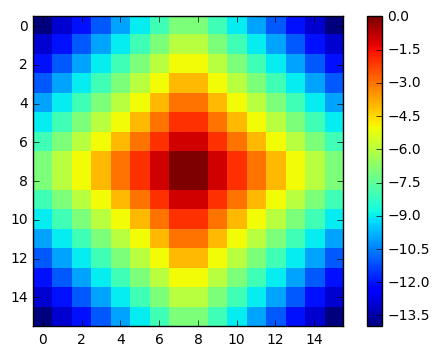

In [8]:
rbt = Robot(testmaze.dim)
from matplotlib import pyplot

img = pyplot.imshow(rbt.U_table_to_goal,interpolation='nearest')
pyplot.colorbar(img)
pyplot.show()

In [3]:
maze = Maze("test_maze_01.txt")
cells = [["   " for x in range(maze.dim)] for row in range(maze.dim)]
show_multiple_path(testmaze,[testrobots[-3].best_path])
#print_maze(maze,cells)

steps:18
                            LEFT                        
          0   1   2   3   4   5   6   7   8   9   10  11 
        +---+---+---+---+---+---+---+---+---+---+---+---+
     0  | 0       0                                     |
        +---+---    +---+---+---    +---    +---+---    +
     1  | 0       0 |                   |               |
            +---            +---    +---+---+---    +---+
     2  |       |   |   |               |               |
                        +---    +---        +---+---+---+
     3  |   |           |               |               |
            +---+---+---    +---+---+---+---+---        +
     4  | 0       0 |                           |   |   |
DOWN    +---+---            +---+---        +---        +  UP
     5  |               |   |       |   |       |   |   |
            +---                                        +
     6  |     0   0 |       |     0 |       |           |
        +---    +---    +---+---    +---        +---    +
  

In [ ]:
scores = []
for result in all_results:
    scores.append(result['first1'].mean())
    
from matplotlib import pyplot as plt
plt.scatter(rewards,np.array(scores))
plt.show()

In [8]:
def show_step_count(maze,path):
    cells = [["   " for x in range(maze.dim)] for row in range(maze.dim)]
    #symbol = (x for x in [" X "," O "," "])
    for i,x in enumerate(path[::-1]):
        if i < 10: 
            cells[x[0]][x[1]] = " {} ".format(i)
        else:
            cells[x[0]][x[1]] = " {}".format(i)
    steps = len(path)-1
    print("steps:{}").format(steps)
    print_maze(maze,cells)

def show_multiple_path(maze,paths):
    cells = [["   " for x in range(maze.dim)] for row in range(maze.dim)]
    #symbol = (x for x in [" X "," O "," "])
    for i,path in enumerate(paths):
        for x in list(set(path)):
            if cells[x[0]][x[1]] == "   ": 
                cells[x[0]][x[1]] = " {} ".format(i)
            else:
                cells[x[0]][x[1]] = cells[x[0]][x[1]][:2] + str(i)
    steps = np.sum([len(x) for x in paths])-1
    print("steps:{}").format(steps)
    print_maze(maze,cells)
    
def show_times_visited(maze,path):
    cells = [["   " for x in range(maze.dim)] for row in range(maze.dim)]
    #symbol = (x for x in [" X "," O "," "])
    times_visited = {x:0 for x in path}
    for x in path:
        times_visited[x] += 1
    for x in list(set(path)):
        cells[x[0]][x[1]] = " {} ".format(times_visited[x])
        
    print("steps:{}").format(len(path))
    print_maze(maze,cells)

In [37]:
import tester
%run tester test_maze_08.txt

Starting run 0.
Ending first run. Starting next run.
Starting run 1.
Goal found; run 1 completed!
Task complete! Score: 23.500
